#### Upload dataset from google drive

In [14]:
!pip install gdown
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.76.0-cp312-cp312-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.15.1-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached rich-14.2.0

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\markdown_py.exe' -> 'C:\\Python312\\Scripts\\markdown_py.exe.deleteme'


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import gdown
import zipfile
from pathlib import Path

from pathlib import Path
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
# Downloading Dataset and extracting data points
file_id = "1unDpBmcZidHfTgKyqaMnh6EMcdVeBvzw"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("data")
import os
os.remove(output)

Downloading...
From (original): https://drive.google.com/uc?id=1unDpBmcZidHfTgKyqaMnh6EMcdVeBvzw
From (redirected): https://drive.google.com/uc?id=1unDpBmcZidHfTgKyqaMnh6EMcdVeBvzw&confirm=t&uuid=cb50d81c-8455-4dac-bea9-1fa42f5db0e4
To: c:\Users\Thejas\Documents\Classes\F25\Computational_Methods\HWs\cs4372_hw3\cs4372_hw3\dataset.zip
100%|██████████| 574M/574M [00:26<00:00, 21.4MB/s] 


#### Load dataset from folders into numpy arrays

In [20]:
def load_dataset(data_dir, image_size=(128, 128)):
    data_dir = Path(data_dir)
    images = []
    labels = []

    classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    for label_index, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in [".jpg", ".png", ".jpeg"]:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img) / 255.0)  # normalize to [0,1]
                labels.append(label_index)

    return np.array(images), np.array(labels), classes

# Training/Test Split
X_train, y_train, classes = load_dataset("data/training/training")
X_test, y_test, _ = load_dataset("data/validation/validation")

print("Training images:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test images:", X_test.shape)
print("Test labels:", y_test.shape)

Training images: (1097, 128, 128, 3)
Training labels: (1097,)
Test images: (272, 128, 128, 3)
Test labels: (272,)


#### Convert numpy arrays into _TensorSliceDataset, make the test dataset from the validation set

In [33]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 218
Number of test batches: 54


#### Plot some training data points

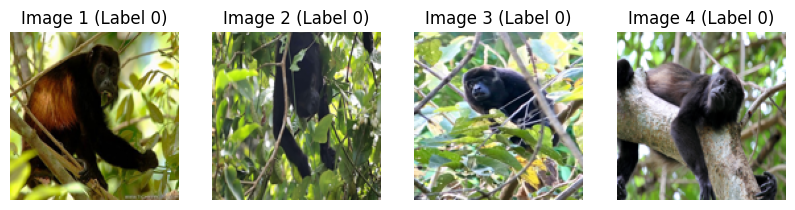

In [32]:
plt.figure(figsize=(10, 5))

for i, (image, label) in enumerate(training_dataset.take(4)):  
    image_numpy = image.numpy()  # convert image tensor → numpy

    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image_numpy)
    plt.title(f"Image {i+1} (Label {label.numpy()})")
    plt.axis("off")

plt.show()

#### Configure datasets (shuffle, batch, prefetch)

In [ ]:
training_dataset = training_dataset.shuffle(buffer_size=len(X_train))
training_dataset = training_dataset.batch(batch_size=32)

validation_dataset = validation_dataset.shuffle(buffer_size=len(X_train))
validation_dataset = validation_dataset.batch(batch_size=32)

training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#### Data Augmentation

In [39]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
])

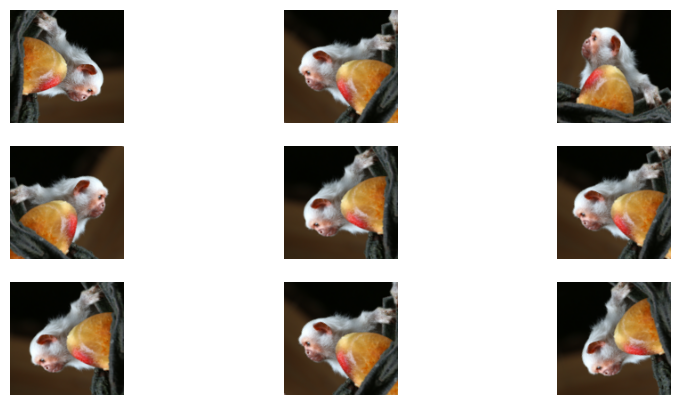

In [ ]:
plt.figure(figsize=(10, 5))

for images, labels in training_dataset.take(1):  
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

plt.show()

#### Rescale pixel values to fit MobileNetV2

In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Create base model MobileNet V2 (before hyperparameter tuning)